In [1]:
import os
import re
import random
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
DATASETS_FOLDER = 'movielens-1m'
USERS_FILE = 'users.dat'
MOVIES_FILE = 'movies.dat'
RATINGS_FILE = 'ratings.dat'
USERS_COLUMNS = ['user_id', 'gender', 'age', 'occupation', 'zipcode']
MOVIES_COLUMNS = ['movie_id', 'title', 'genres']
RATINGS_COLUMNS = ['user_id', 'movie_id', 'rating', 'timestamp']

In [3]:
def read_dataset(file_name, columns):
    file_path = os.path.join('/kaggle', 'input', DATASETS_FOLDER, file_name)
    df = pd.read_csv(file_path, sep='::', engine='python', header=None, names=columns, encoding='latin-1')

    return df

In [4]:
def load_datasets():
    users = read_dataset(USERS_FILE, USERS_COLUMNS)
    movies = read_dataset(MOVIES_FILE, MOVIES_COLUMNS)
    ratings = read_dataset(RATINGS_FILE, RATINGS_COLUMNS)

    return users, movies, ratings

In [5]:
users_df, movies_df, ratings_df  = load_datasets()

In [6]:
print(users_df.head())
print(movies_df.head())
print(ratings_df.head())

   user_id gender  age  occupation zipcode
0        1      F    1          10   48067
1        2      M   56          16   70072
2        3      M   25          15   55117
3        4      M   45           7   02460
4        5      M   25          20   55455
   movie_id                               title                        genres
0         1                    Toy Story (1995)   Animation|Children's|Comedy
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy
2         3             Grumpier Old Men (1995)                Comedy|Romance
3         4            Waiting to Exhale (1995)                  Comedy|Drama
4         5  Father of the Bride Part II (1995)                        Comedy
   user_id  movie_id  rating  timestamp
0        1      1193       5  978300760
1        1       661       3  978302109
2        1       914       3  978301968
3        1      3408       4  978300275
4        1      2355       5  978824291


### Data Processing
1. **Extract the Release Year**
2. **Remove the Year from Movie Titles**
3. **Separate Genres into Distinct Boolean Columns**
4. **Add a Column for Mean Rating**
5. **Add a Column for Number of Ratings**

In [7]:
def extract_year(title):
    year_match = re.search(r'\(\d{4}\)', title)
    if year_match: 
        return int(year_match.group()[1:-1])
    
    return None

def calculate_period(year):
    return (year // 5) * 5

def delete_year(title):
    if re.search(r'\(\d{4}\)', title):
        return title[:-6].strip()
    
    return title

def add_binary_genre_columns_to_movies(movies_df):
    movies_df = movies_df.copy(deep=True)
    
    if 'genres' not in movies_df:
        return movies_df, []
    
    movies_df['genres'] = movies_df['genres'].str.split('|').apply(lambda genre_columns: [genre.replace("'", "").lower() for genre in genre_columns])
    genre_columns = movies_df['genres'].explode().unique()
    for genre in genre_columns:
        movies_df[genre] = movies_df['genres'].apply(lambda x: genre in x).astype(int)
    movies_df = movies_df.drop('genres', axis=1)
    
    return movies_df, genre_columns

def add_mean_rating_to_movies(movies_df, ratings_df):
    movies_df = movies_df.copy(deep=True)
    
    mean_ratings = ratings_df.groupby('movie_id')['rating'].mean().reset_index()
    mean_ratings.rename(columns={'rating': 'mean_rating'}, inplace=True)
    movies_df = pd.merge(movies_df, mean_ratings, on='movie_id', how='left')
    
    return movies_df

def add_number_of_ratings_to_movies(movies_df, ratings_df):
    movies_df = movies_df.copy(deep=True)
    
    ratings_count = ratings_df['movie_id'].value_counts().reset_index()
    ratings_count.columns = ['movie_id', 'num_ratings']
    movies_df = pd.merge(movies_df, ratings_count, on='movie_id', how='left')
    
    return movies_df

In [8]:
movies_df['year'] = movies_df['title'].apply(extract_year)
movies_df['period'] = movies_df['year'].apply(calculate_period)
movies_df, genre_columns = add_binary_genre_columns_to_movies(movies_df)

movies_df

,movie_id,title,year,period,animation,childrens,comedy,adventure,fantasy,romance,...,crime,thriller,horror,sci-fi,documentary,war,musical,mystery,film-noir,western
0,1,Toy Story (1995),1995,1995,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),1995,1995,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),1995,1995,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),1995,1995,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),1995,1995,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,3948,Meet the Parents (2000),2000,2000,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3879,3949,Requiem for a Dream (2000),2000,2000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3880,3950,Tigerland (2000),2000,2000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3881,3951,Two Family House (2000),2000,2000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
print(genre_columns)

['animation' 'childrens' 'comedy' 'adventure' 'fantasy' 'romance' 'drama'
 'action' 'crime' 'thriller' 'horror' 'sci-fi' 'documentary' 'war'
 'musical' 'mystery' 'film-noir' 'western']


In [10]:
def plot_genre_counts(movies_df, genre_columns):
    genre_counts = movies_df[genre_columns].sum()

    plt.figure(figsize=(12, 6))
    genre_counts.plot(kind='bar', color='dodgerblue')
    plt.title('Number of movies per genre')
    plt.xlabel('Genre')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()

In [11]:
def plot_top_years(movies_df, top_n=15):
    top_years = movies_df['year'].value_counts().head(top_n).sort_index(ascending=False)
    
    plt.figure(figsize=(12, 6))
    top_years.plot(kind='bar', color='gold')
    plt.title(f'Top {top_n} years with the most movies')
    plt.xlabel('Year')
    plt.ylabel('Number of Movies')
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()

In [12]:
def plot_top_users_with_most_ratings(users_df, ratings_df, top_n=15):
    merged_df = pd.merge(ratings_df, users_df, on='user_id', how='inner')
    user_ratings_counts = merged_df['user_id'].value_counts().head(top_n).sort_index(ascending=False)
    
    plt.figure(figsize=(12, 6))
    user_ratings_counts.plot(kind='bar', color='firebrick')
    plt.title(f'Top {top_n} users with the most ratings')
    plt.xlabel('User ID')
    plt.ylabel('Number of Ratings')
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()

In [13]:
def plot_user_genre_ratings(users_df, movies_df, ratings_df, genre_columns, user_id=4169):
    user_ratings = ratings_df[ratings_df['user_id'] == user_id]
    user_movie_data = pd.merge(user_ratings, movies_df, on='movie_id', how='inner')
    genre_counts = user_movie_data[genre_columns].sum()

    plt.figure(figsize=(12, 6))
    genre_counts.plot(kind='bar', color='dodgerblue')
    plt.title(f'Movies rated by user {user_id} in each genre')
    plt.xlabel('Genre')
    plt.ylabel('Number of Movies Rated')
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()

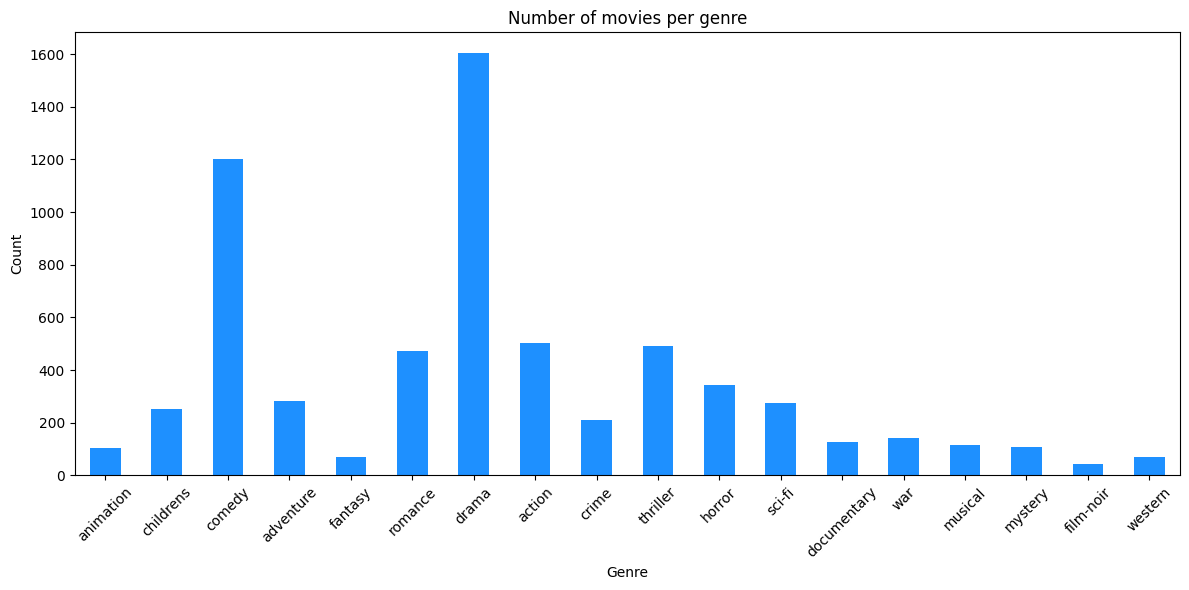

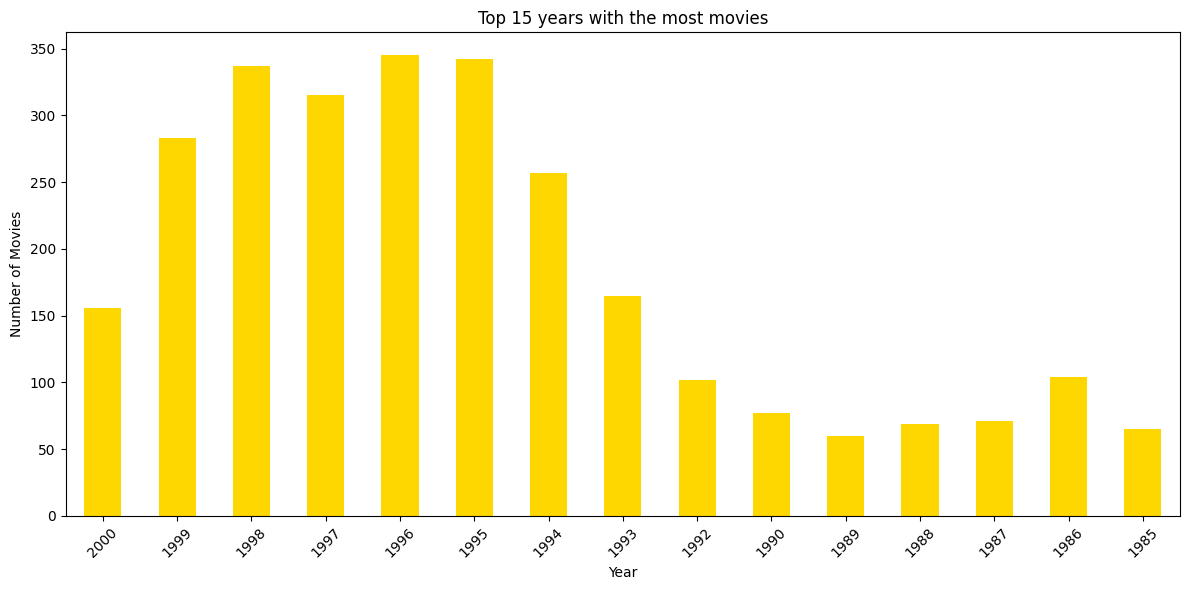

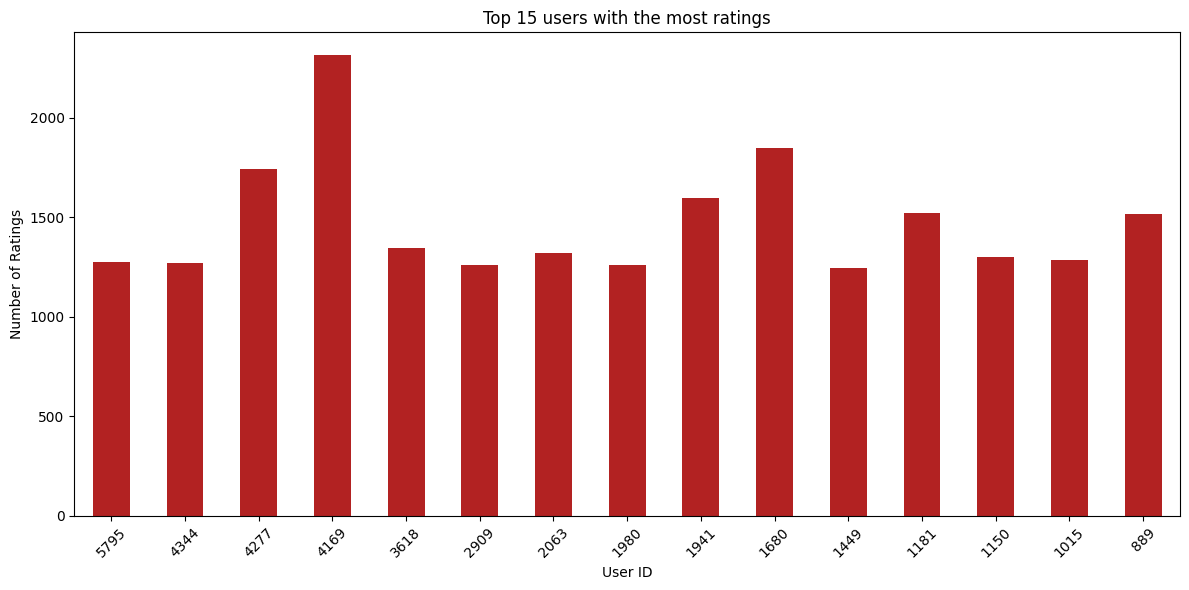

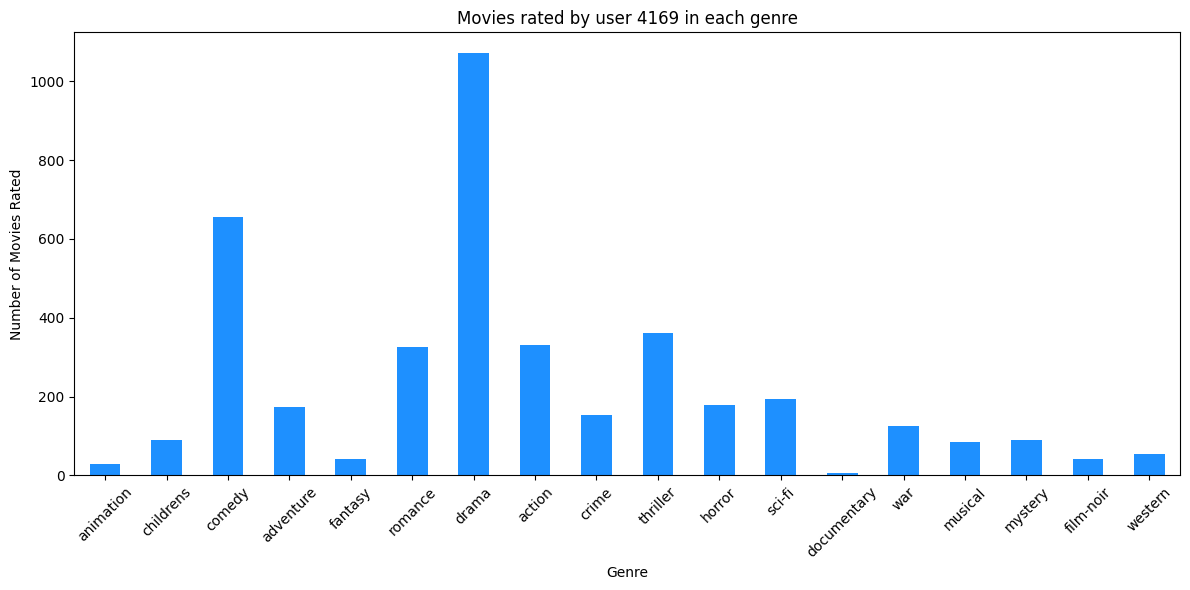

In [14]:
plot_genre_counts(movies_df, genre_columns)  
plot_top_years(movies_df)
plot_top_users_with_most_ratings(users_df, ratings_df)
plot_user_genre_ratings(users_df, movies_df, ratings_df, genre_columns)

In [15]:
class PeriodGenreBasedMovieRecommender:
    def __init__(self, movies, ratings, genre_columns):
        self.movies = movies
        self.ratings = ratings
        self.genre_columns = genre_columns
        self.Q_values = {}
        self.alpha=0.1
        self.gamma=0.9
        self.epsilon=0.1
        
    def get_user_history(self, user_id):
        user_ratings = self.ratings[self.ratings['user_id'] == user_id].sort_values(by='timestamp', ascending=True).merge(self.movies, on='movie_id')
        return user_ratings[['movie_id', 'rating', 'period', *self.genre_columns]]
    
    
    def initialize_Q_values(self):
        all_periods = self.movies['period'].unique()
        for period in all_periods:
            for genre in self.genre_columns:
                self.Q_values[(period, genre)] = 0
    
    
    def select_genre(self, movie_row):
        available_genres = [genre for genre in self.genre_columns if movie_row[genre] == 1]
        return np.random.choice(available_genres) if available_genres else np.random.choice(self.genre_columns)
    
    
    def select_action(self, state, epsilon):
        if np.random.rand() < epsilon:
            filtered_movies = self.movies[(self.movies['period'] == state[0]) & (self.movies[state[1]] == 1)]
            return random.choice(filtered_movies['movie_id'].tolist()) if not filtered_movies.empty else None
        else:
            filtered_movies = self.movies[(self.movies['period'] == state[0]) & (self.movies[state[1]] == 1)]
            best_movie = None
            best_Q_value = -np.inf
            for _, movie in filtered_movies.iterrows():
                movie_id = movie['movie_id']
                Q_value = self.Q_values.get((state[0], state[1]), 0)
                if Q_value > best_Q_value:
                    best_Q_value = Q_value
                    best_movie = movie_id
            return best_movie

        
    def update_Q_values(self, current_state, reward, next_state):
        current_Q = self.Q_values.get(current_state, 0)
        max_next_Q = max([self.Q_values.get((next_state[0], g), 0) for g in self.genre_columns])
        updated_Q = current_Q + self.alpha * (reward + self.gamma * max_next_Q - current_Q)
        self.Q_values[current_state] = updated_Q

        
    def train(self, user_id):
        user_history = self.get_user_history(user_id)
        self.initialize_Q_values()

        for i in range(len(user_history) - 1):
            current_row = user_history.iloc[i]
            next_row = user_history.iloc[i + 1]

            current_state = (current_row['period'], self.select_genre(current_row))
            next_state = (next_row['period'], self.select_genre(next_row))

            current_movie = self.select_action(current_state, self.epsilon)
            next_movie = self.select_action(next_state, self.epsilon)

            reward = next_row['rating']
            self.update_Q_values(current_state, reward, next_state)
            
            
    def recommend_movies(self, user_id, top_n=5):
        self.train(user_id)
        watched_movie_ids = set(self.get_user_history(user_id)['movie_id'])  
        
        sorted_Q_values = sorted(self.Q_values.items(), key=lambda item: item[1], reverse=True)
        recommended_movies_titles = []
        for (period, genre), _ in sorted_Q_values[:top_n]:
            recommended_movies = self.movies[(self.movies['period'] == period) & (self.movies[genre] == 1) & (~self.movies['movie_id'].isin(watched_movie_ids))]
            if not recommended_movies.empty:
                recommended_movie_id = recommended_movies.iloc[0]['movie_id']
                watched_movie_ids.add(recommended_movie_id)
                recommended_movies_titles.append(recommended_movies.iloc[0]['title'])

        return recommended_movies_titles

In [16]:
recommender = PeriodGenreBasedMovieRecommender(movies_df, ratings_df, genre_columns)
print(recommender.recommend_movies(4169))

['Guardian Angel (1994)', 'Wings of Courage (1995)', 'Shopping (1994)', 'Lawnmower Man 2: Beyond Cyberspace (1996)', 'Relative Fear (1994)']
